# 1 Introducción

El siguiente ejemplo modifica el color de una imágen parametrizada, a escala de grises. El cálculo de la escala se realiza convirtiendo los 3 canales RGB, que representan a los colores R (*rojo*)-G(*verde*)-B(*azul*), de cada pixel siguiendo la ecuación:

<center>$ Pixel=R*0.30+G*0.59+B*0.11$</center>

EL objetivo es enseñar el funcionamiento del Lenguaje Python, CUDA y el manejo de imagenes a bajo nivel. El ejemplo es ilustrativo, ya que internamente el módulo Pillow posee varios filtros integrados.

---
# 2 Armado del ambiente
Toma la direcciòn web de una imagen con  acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

In [5]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://i.pinimg.com/originals/be/4a/98/be4a98faeda134f012cc442bd67536a7.jpg" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()


--2020-11-17 16:47:05--  https://i.pinimg.com/originals/be/4a/98/be4a98faeda134f012cc442bd67536a7.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.188.84, 2a04:4e42:a::84
Connecting to i.pinimg.com (i.pinimg.com)|151.101.188.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72849 (71K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]  71.14K  --.-KB/s    in 0.02s   

2020-11-17 16:47:05 (3.40 MB/s) - ‘imagen.jpg’ saved [72849/72849]



---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [6]:
!pip install pycuda

---
# 3 Desarrollo
Ejecución del algoritmo escala de grises en GPU.

Tiempo TOTAL:  501.807 [ms]
Tiempo GPU  :  0.147 [ms]


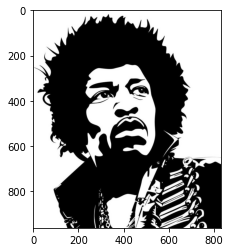

In [42]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# ------------------------------------------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos --------------
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# ------------------------------------------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_alto, img_ancho = image.size 

# Arrays para guardar los pixels de color negro.
arrayint = numpy.random.randn(img_alto*img_alto)
nx = numpy.empty_like(arrayint)
ny = numpy.empty_like(arrayint)

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.array(image)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
nx_gpu  = cuda.mem_alloc( nx.nbytes )
ny_gpu  = cuda.mem_alloc( ny.nbytes )
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, char *img_O, char * x_gpu, char * y_gpu)
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;

  //int color = img_pic_cpu[y][x];

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    if ((float)img_O[(idx+(idy*ancho))*3] == 0.0 && (float)img_O[((idx+(idy*ancho))*3)+1] == 0.0 && (float)img_O[((idx+(idy*ancho))*3)+2] == 0.0)
    {
      x_gpu[idx] = (idx);
      y_gpu[idy] = (idy);
    }
  }
}
""")

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
# print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

# print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
# print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel(numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, nx_gpu, ny_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( nx, nx_gpu )
cuda.memcpy_dtoh( ny, ny_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
nnax = numpy.array(nx)
nnay = numpy.array(ny)

filter_x = []; filter_y = [];
for element in nnax:
  if element != 666:
    filter_x.append(element)
    filter_y.append(element)

radii = numpy.random.random(size= len(filter_x)) * 0.25

# colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(numpy.floor(50+2*filter_x).astype(int), numpy.floor(30+2*filter_y).astype(int))]

result = figure()
# result.circle(filter_x, filter_y, radius=radii, fill_color=colors, fill_alpha=0.6, line_color=None)
show(result)

tiempo_representacion = datetime.now()
tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )

---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  wget url_imagen       | Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline    | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el còdigo del kernel.
CPU      |  module.get_function() | convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  print()               | Informa los atributos de la imagen.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.



---
# 5 Conclusiones

Las conclusiones son explicadas en clase...

---
# 6 Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] 2009, SINTESIS DIGITAL DE COLOR UTILIZANDO TONOS DE GRIS, ING. JESÚS GUSTAVO FLORES ERAÑA : [PDF](https://ninive.uaslp.mx/xmlui/bitstream/handle/i/2264/MCA1SDC00901.pdf?sequence=1&isAllowed=y)
